In [16]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
#import astropy.constants as C
import astropy.units as U
from astropy.convolution import Gaussian2DKernel
import galsim
from astropy.convolution import convolve_fft
from morphsed import Galaxy, AGN, Galaxy3D
from astropy.modeling.models import Sersic2D
from morphsed.plot import plotIFU

import morphsed.sed_interp as SEDs
import morphsed.emission_lines as ELs

import time,csv,lmfit
from csst_slitless_calibration.IFUDisperser.disperser import MockSpectrum, IFUDisperser
U_SPEC_WAVE = U.erg/(U.s * U.cm**2 * U.AA)
from csst_slitless_calibration.utils import *
from csst_slitless_calibration.axeconf import aXeConfCSST, aXeConfHST
from csst_slitless_calibration.data import LINES, DATADIR
from csst_slitless_calibration.IFUDisperser.disperser import *
from csst_slitless_calibration.utils.cds9 import cDS9
from pathlib import Path
import sys
sys.path.append('/Users/liruancun/Works/accretion/')
sys.path.append('/Users/liruancun/Works/BH/')
sys.path.append('/Users/liruancun/Works/merger/')
import Constant as C

# Read flt file

In [ ]:
targname = 'j024020m0126'
ra = 40.08490
dec = -1.44083

In [2]:
wavelength=np.logspace( np.log10(3000), np.log10(10000), 2001) # wavelength grid

## parameters of Telescope and instrument
p_size  = 0.074 # in arcsec/pixel
aper    = 2     # im meter

## parameters of PSF
N_psf = 31
psf = galsim.Gaussian(fwhm=0.39)
psf_image = psf.drawImage(wcs=galsim.PixelScale(p_size), nx=N_psf, ny=N_psf).array

# parameters of the observation and the object
exptime  = 150              # in s
nxi, nyi = 9232, 9216       # size of the grism image (CSST size), i means image
xc, yc   = 4000.75, 4000.25 # center position of the object, x and y start from 0
nxs, nys = 100, 100         # stamp size, s means stamp

# ixmin, iymin is the left,bottom corner of the stamp
#   the object is also (roughly) at the center of the stamp image
ixmin = int(int(xc) - (nxs-1)/2)
iymin = int(int(yc) - (nys-1)/2)

# grism disperser config file
#AXECONF = DATADIR/'hst_conf/G141.F105W.V4.32.conf'

In [4]:
DATADIR

PosixPath('/Users/liruancun/Works/GitHub/slitless_calibration/csst_slitless_calibration/data')

In [3]:
Mygalaxy = Galaxy3D(mass = 1e11,z=0.03,ebv_G=0.07)
bulgeparams={'xcen': 50.0, 'ycen': 50.0, 'frac': 30.0, 're': 10.0, 'nser': 3.0, 'ang': -32.70422048691768, 'axrat': 1.0, 'box': 0.0, 'convolve': False}
diskparams={'xcen': 50.0, 'ycen': 50.0, 'frac': 70.0, 're': 35.0, 'nser': 1.0, 'ang': -32.70422048691768, 'axrat': 0.5, 'box': 0.0, 'convolve': False}
age = {'type': "linear", 'paradic':{'k':-0.05, 'b':9.}}
Z = {'type': "linear", 'paradic':{'k':0., 'b':0.02}}
f_cont = {'type': "const", 'paradic':{'value': 0.05}}
Av = {'type': "const", 'paradic':{'value': 1.5}}
sigma = {'type': "const", 'paradic':{'value': 150}}
Mygalaxy.add_subC('sersic',bulgeparams,age,Z,f_cont,Av,sigma)
age = {'type': "linear", 'paradic':{'k':0., 'b':0.1}}
Z = {'type': "linear", 'paradic':{'k':0., 'b':0.02}}
f_cont = {'type': "const", 'paradic':{'value': 0.85}}
Av = {'type': "const", 'paradic':{'value': 1.0}}
sigma = {'type': "const", 'paradic':{'value': 80}}
Mygalaxy.add_subC('sersic',diskparams,age,Z,f_cont,Av,sigma)
psfFWHM=1.44
psf = Gaussian2DKernel(psfFWHM, x_size=15, y_size=15)
psf.normalize()
totalmass = Mygalaxy.generate_mass_map((100,100),np.array(psf))
r_curve = {
    'function_name':'arctan',
    'params':{'v0':0.,'vc':220.,'r0':0.,'rt':20.,},
}
geometry = {
            'xcen' : 50.,
            'ycen' : 50., # in pix
            'i'  :  60.,      # in degree, arccos(axis ratio of disk)
            'PA' :  57.3, # in degree 90+ position angle of disk
            'rotation_curve': r_curve, # {'function_name','params'}
        }
v_map = Mygalaxy.geometry_3D(geometry)
lines = [ELs.OII,ELs.NeIII,ELs.Hg,ELs.Hb,ELs.Ha,ELs.OIII_4959,ELs.OIII_5007,ELs.HeI,ELs.OI_6302,
         ELs.NII_6549,ELs.NII_6583,ELs.SII_6716,ELs.SII_6731]
amplist = []
mod = Sersic2D(amplitude = 1., r_eff = 35, n=1, x_0=50, y_0=50, ellip=1.-np.sqrt(0.75), theta=57.3*np.pi/180)
x,y = np.meshgrid(np.arange(100), np.arange(100))
sbp_line_fidutial =  mod(x, y)
sbp_line_fidutial *= 1./np.sum(sbp_line_fidutial)
with open("{0}/templates/line_test.csv".format(SEDs.DATA_PATH), mode='r') as infile:
    reader = csv.reader(infile)
    mydict = dict((rows[0],float(rows[1])) for rows in reader)
C_unit = mydict['SSP1C_unit']
for line in lines:
    if line['name'] == 'NaD':
        amplist.append(sbp_line_fidutial*mydict['HeIa1amplitude']/C_unit)
    else:
        amplist.append(sbp_line_fidutial*mydict['{0}n1amplitude'.format(line['name'])]/C_unit)
sigmap = np.ones((100,100))*3.5*SEDs.c/ELs.OIII_5007['wave']

In [4]:
start_t = time.time()
IFU = Mygalaxy.generate_SED_IFU(wavelength,resolution=10, highres=False)
EL_IFU = Mygalaxy.emission_line(wavelength,lines,amplist,sigmap)
stop_t = time.time()
print ("elapse time {0:.2f} s".format(stop_t-start_t))

elapse time 9.89 s


In [5]:
par_total = lmfit.Parameters()
par_total.add('agn_logM', value=7., min=5., max=10.,vary=False)
par_total.add('agn_logLedd', value=-1.5, min=-4, max=2.)
par_total.add('agn_spin', value=0., min=0., max=0.99,vary=False)
Myagn = AGN(logM_BH=par_total['agn_logM'].value,logLedd= par_total['agn_logLedd'].value,
                    astar=par_total['agn_spin'].value,Av =0., z=0.03, ebv_G=0.07)
lines_broad = [ELs.Hg,ELs.Hb,ELs.Ha]
lines_narrow = [ELs.OIII_5007]
par_BLR,par_NLR = Myagn.set_full_model([wavelength,IFU[50,50,:]],lines_broad,lines_narrow)
par_BLR['BaCcf'].set(0.001)
par_BLR['BaCfwhm'].set(expr='61.69*Hbb1fwhm')
par_BLR['Hab1sigma'].set(60)
par_BLR['Hab1amplitude'].set(2e41)
par_BLR['Hbb1sigma'].set(50)
par_BLR['Hbb1amplitude'].set(0.7e41)
par_total.update(par_BLR)
AGN_IFU = Myagn.generate_SED_IFU(wavelength, (100,100), [50,50], par_total)

In [28]:
#par_BLR

In [6]:
tot_IFU = IFU + EL_IFU + AGN_IFU
IFU_cov = tot_IFU.copy()
for loop in range(len(wavelength)):
    IFU_cov[:,:,loop] = convolve_fft(tot_IFU[:,:,loop],psf) 

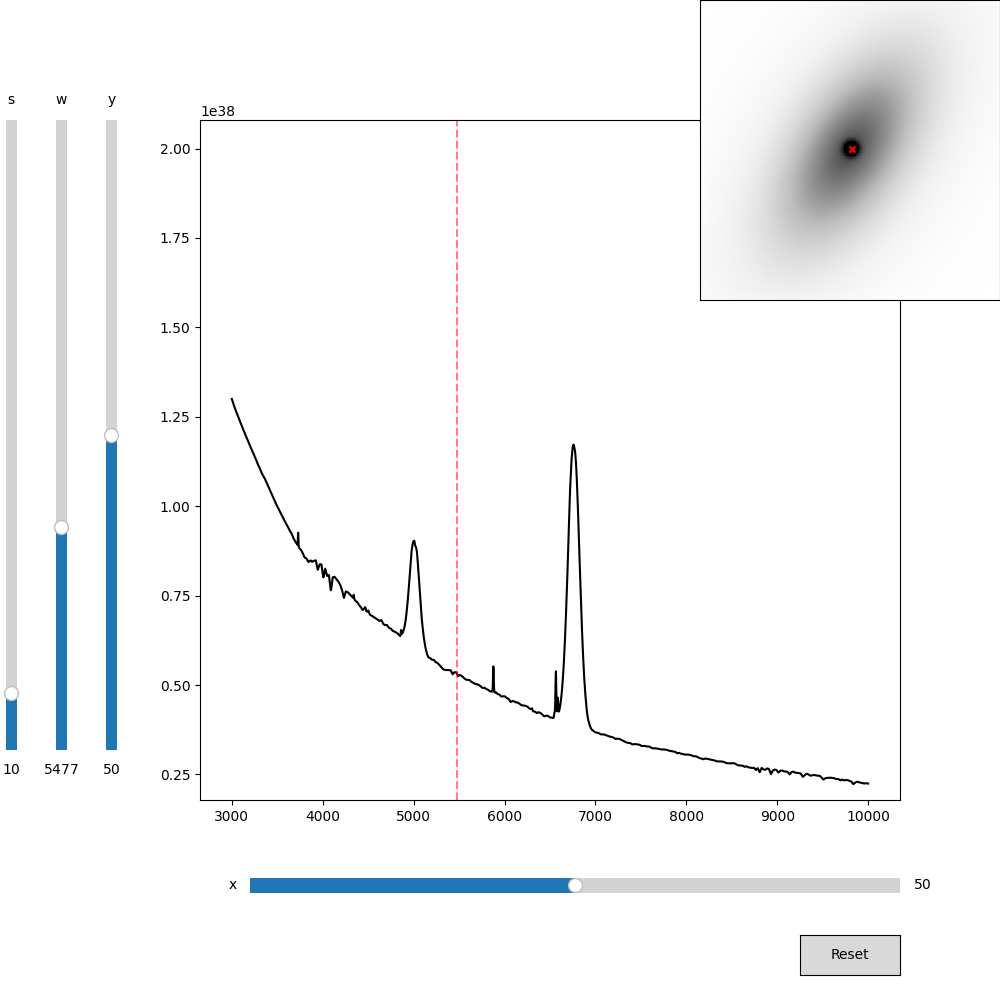

In [9]:
fig = plotIFU(wavelength,IFU_cov)
plt.show(block=False)

In [10]:
# init IFUDisperser
disperser = IFUDisperser(
  nx=nxi, ny=nyi,
  axeconf=AXECONF,
  aper=aper,
  psf=psf_image
)

Exception: unknown band type: G141.F105W.V4.32.conf

/Users/liruancun/Works/GitHub/slitless_calibration/csst_slitless_calibration/data


In [13]:
axeconf = aXeConfHST(axeconf_file)

In [11]:
#factor = 1  / beam.PAM_value
pad = 256
#wave = flt.object_dispersers[bid][1][0].astype(np.float64) * U.AA
#spec = flt.object_dispersers[bid][1][1].astype(np.float64) * U_SPEC_WAVE
#this_spec_table = Table({'WAVELENGTH': wave, 'FLUX': spec})
#header = fits.Header({'OBJECT': result['simbad_name'] + '|' + str(result['mast_target']) + f'-{bid}', 'EXTNAME': f'SPEC1D_{bid}'})
#spec_hdu = fits.BinTableHDU(this_spec_table, header=header)
#spec_hdus.append(spec_hdu)

#pad = beam.pad

axeconf_file = Path('/Users/liruancun/Works/GitHub/slitless_calibration/csst_slitless_calibration/data/hst_conf/G141.F105W.V4.32.conf')
axeconf = aXeConfHST(axeconf_file)
nyi, nxi = flt.seg.shape
nyi -= pad*2
nxi -= pad*2
idisperser = IFUDisperser(
  nx=nxi, ny=nyi,
  axeconf=axeconf,
  psf=None,
  pad=pad,
)
xc=(beam.xc+beam.xcenter-beam.pad)/beam.grow
yc=(beam.yc+beam.ycenter-beam.pad)/beam.grow

iymin = sdirect_y.start - pad
ixmin = sdirect_x.start - pad

nys, nxs = beam.direct.shape

# image method
simage = beam.direct.copy()
simage_mask = beam.seg == bid
simage[~simage_mask] = 0
stamp = simage / simage.sum() # stamp is always normalized
print(f'==> {flt_index}:{band} {bid} {bname} stamp max:{stamp.max()}, spec_max:{this_spec_table["FLUX"].max()}')
just_use_grizli_result = False
if this_spec_table["FLUX"].max()>1:
  just_use_grizli_result = True
  print(f'bad spectrum for {bid}, just use old result')
fibeams = idisperser.get_spec_orders_with_fixed_image(
  stamp=stamp, spec=this_spec_table,
  xc=xc, yc=yc,
  ixmin=ixmin, iymin=iymin,
  psf=False,
)
figrism = idisperser.beam2image(fibeams)
figrism = figrism * factor
if just_use_grizli_result:
  our_ibeam_model_data += this_beam_model_data
else:
  our_ibeam_model_data += figrism
# debugi_bid['fibeams'] = fibeams
# debugi_bid['figrism'] = figrism

# image => ifu data, but calculate dispersion functions at single position
print(f'doing {flt_index} {bid} {bname} image_ifu...')
fiibeams = idisperser.get_spec_orders_with_fixed_image_with_ifu(
  stamp=stamp, spec=this_spec_table, seg=simage_mask,
  ixmin=ixmin, iymin=iymin,
  xc=xc, yc=yc,
  psf=False,
)
fiigrism = idisperser.beam2image(fiibeams)
fiigrism = fiigrism * factor
our_iibeam_model_data += fiigrism
# debugi_bid['fiibeams'] = fiibeams
# debugi_bid['fiigrism'] = fiigrism


# full ifu method
print(f'doing {flt_index} {bid} {bname} ifu...')
if 'make ifu data':
  _flux_x = this_spec_table['WAVELENGTH'].data
  _flux_y = this_spec_table['FLUX'].data

  _stamp = stamp.copy()
  stamp_reshaped = _stamp.reshape((nys, nxs, 1))
  ifu_flux = _flux_y * stamp_reshaped

fiiibeams = idisperser.get_spec_orders(
  wave=_flux_x, ifu=ifu_flux, seg=simage_mask,
  ixmin=ixmin, iymin=iymin,
  bin=5,
  psf=False,
  debug=True,
)
fiiigrism = idisperser.beam2image(fiiibeams)
fiiigrism = fiiigrism * factor
our_iiibeam_model_data += fiiigrism

Exception: unknown band type: G141.F105W.V4.32.conf

In [26]:
for i in range(3):
    t0 = time.time()
    beams = disperser.get_spec_orders(
        wave=wavelength,
        ifu=IFU,
        ixmin=ixmin, iymin=iymin,
        exptime=exptime,
        psf=True,
        bin=3,
        debug=True,
        beams=['A']
    )
    print(f'calculate beams at {i} times in {time.time()-t0:.2f}s')

calculating dxdylam 3d for ((3950, 3950))+(100,100):3:A:3000.0:10000.0
	 in 5.37s
  prepare A in 5.37s
calculate A in 5.37s + 0.13s
calculate beams at 0 times in 5.51s
  prepare A in 0.00s
calculate A in 0.00s + 0.13s
calculate beams at 1 times in 0.14s
  prepare A in 0.00s
calculate A in 0.00s + 0.14s
calculate beams at 2 times in 0.14s


In [91]:
Mygalaxy.redshift

0.03

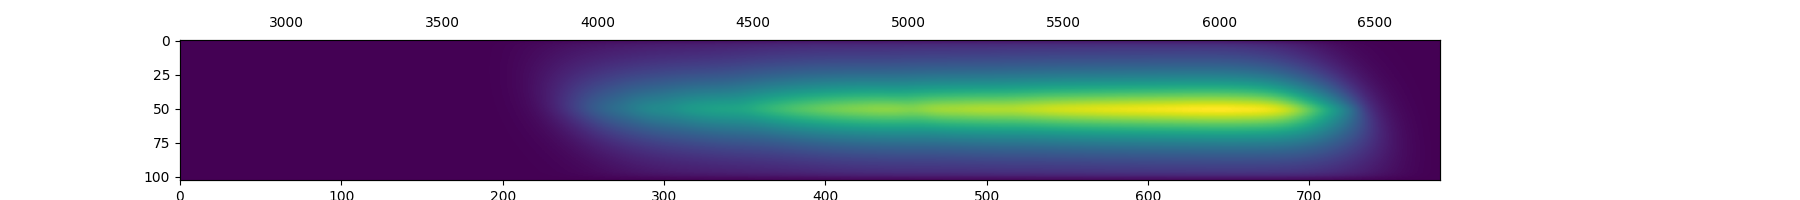

In [27]:
grism_image = beams['A']['beam']
if 'show grism beam':
    fig = plt.figure(figsize=(18,2))
        
    ax1 = fig.add_axes([0.1,0.1, 0.7, 0.7])
    ax1.xaxis.set_tick_params(labeltop=True)
    ax1.xaxis.set_tick_params(labelbottom=False)
    ax1.xaxis.set_tick_params(bottom=False)
    ax1.yaxis.set_tick_params(labelleft=False)
    ax1.yaxis.set_tick_params(left=False)
    xmin = beams['A']['debug']['xmin']
    xmax = beams['A']['debug']['xmax']
    lam_min = beams['A']['debug']['lam'][0]
    lam_max = beams['A']['debug']['lam'][-1]
    trans_func = lambda _: (_-xmin)/(xmax-xmin) * (lam_max-lam_min) + lam_min
    ax1.set_xlim(trans_func(0), trans_func(grism_image.shape[1]-1))

    ax = fig.add_axes([0.1,0.1, 0.7, 0.7])
    ax.imshow(grism_image, aspect='auto')
    ax.set_xlim(0, grism_image.shape[1]-1)
plt.savefig('./slitless.png',dpi=200,bbox_inches='tight')
plt.show(block=False)
time.sleep(2)


In [39]:
s1 = np.pi*1**2*1e-6
s2 = np.pi*0.5**2*1e-6
I = 12
print (I/s1,I/s2,7.5/12*5)

3819718.6342054885 15278874.536821954 3.125
